# Part 4: Train a Model
In the previous notebooks, we covered downloading and working with images, getting ground-truth data from OSM, and converting OSM data into image masks.  Now we can move onto actually training an NN on this data.

But first, we need to assemble a trainnig set, and to do that we're going to have to combine everything we've done up until now.

I'm going to use 3 target categories: residential areas, woods, and water.  The data is pretty sparse, so I want to make sure there are a lot of targets to hit.  That's my main reason for using three targets instead of just one.  Also I'm showing off how easy it is to do that.

In [1]:
import os

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import shapely.geometry

%matplotlib inline

## Create a dataset
Before we can train an NN, we'll need to build a training set.  So I'll iterate through every image of Paris and then create an image mask to train against.

Paris is the smallest dataset in SpaceNet.  I originally thought that would make it a good starting point.  Unfortunately, Paris just doesn't have enough images to train a model well, so I'd suggest starting with another city (which is not what I did #rolemodel).

First, I'm going to load some of the vectors I downloaded in notebook 2.

In [2]:
# Load the image summary
image_summary = gpd.read_file('vectors/image_summary.geojson')

# Load the nature data from OSM
osm_landuse = gpd.read_file('vectors/landuse.geojson')

# Convert everything to polygons
osm_landuse.set_geometry(osm_landuse.geometry.apply(shapely.geometry.Polygon), inplace=True)

# Limit to just residential
residential = osm_landuse[osm_landuse.landuse == 'residential'].unary_union

# Now do the same for woods and water
osm_nature = gpd.read_file('vectors/nature.geojson')
osm_nature.set_geometry(osm_nature.geometry.apply(shapely.geometry.Polygon), inplace=True)
wood = osm_nature[osm_nature.natural == 'wood'].unary_union
water = osm_nature[osm_nature.natural == 'water'].unary_union

vectors = [residential, wood, water]

Now I'll pick out 1000 images and make the corresponding masks.

In [3]:
CROP_SIZE = 640 # I had to crop the images to fit them in U-Net. You should probably change this to random crops

# Recycle a couple of functions from previous notebooks...
def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """Rescale the bands of a multichannel image for display"""
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled

# Build a training set
def make_set(image_summary, vectors, training_set_size, random=np.random):
    rows_to_use = random.choice(image_summary.index, training_set_size, replace=False)
    X = []
    Y = []
    for i, row in image_summary.loc[rows_to_use].iterrows():
        with rasterio.open(row.image_name) as src:
                img = src.read().transpose([1,2,0])
                # img = scale_bands(img, lower_pct = 5, upper_pct = 95)
                img_bounds = shapely.geometry.box(*src.bounds)
                img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])

        masks = []
        for poly in vectors:
            # Get the intersection between the polygon and the image bounds
            mask_poly = poly.intersection(img_bounds)

            # Transform it into pixel coordinates
            mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)

            # Convert the polygon into a mask
            mask = make_mask(img.shape[:2], mask_poly_pxcoords)
            
            masks.append(mask[..., None])
        masks = np.concatenate(masks, axis=2)
        
        # Add each mask to a list
        X.append(img[None, :CROP_SIZE, :CROP_SIZE, :]) # These need to be truncated for U-Net
        Y.append(masks[None, :CROP_SIZE, :CROP_SIZE, :])

            
    # Concatenate the results
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    
    # Normalize the values
    X = X.astype('float32')
    X = (X / X.max() - 0.5) * 2 # put X in range [-1, 1]
    Y = Y.astype('float32') / 255 # put Y in range [0, 1]
    
    return X, Y

random = np.random.RandomState(2) 
X_train, Y_train = make_set(image_summary, vectors, 1000, random)
X_val, Y_val = make_set(image_summary, vectors, 100, random)

## Build a U-Net model
In order to train a Keras model, you have to build it layer by layer.  The `get_unet` function builds a new U-Net model for you with randomly initialized weights.  A word of warning: Keras is a package going through rapid development.  I had an example I used 2 months ago, and it wouldn't run anymore because the Keras package changed since then.  I order to get it working again, I found a repo with an [up-to-date U-Net model in Keras](https://github.com/jocicmarko/ultrasound-nerve-segmentation/) and copied it.  If you want to see a more detailed training procedure, I'd suggest having a look at that repo.  I'm keeping everything simple here so you can learn the basics before you get consumed by all the details of optimizing training routines.  I also borrowed some ideas from a [Kaggle notebook](https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras).

U-Net is a segmentation model that is known for performing well when you train it from scratch on new data.  It is not as powerful as ResNet or FCN, but it has the advantage that you don't need to do transfer learning to get good results.  So I thought it would be a good starting point.  I have no doubt you can get better results by using a more powerful net with transfer learning.

In [4]:
# Source: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

import keras
from keras import backend as K
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam

# Set network size params
N_CLASSES = 3
N_CHANNEL = 8
IMG_DIM = 640

# Define metrics
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Just put a negative sign in front of an accuracy metric to turn it into a loss to be minimized
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def get_unet(lr=0.001):
    inputs = Input((IMG_DIM, IMG_DIM, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=Adam(lr=lr), loss=jacc_coef_loss, metrics=[jacc_coef_int])
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[dice_coef])

    return model


Using TensorFlow backend.


Now that the model is built, we can start training it.  I used a bunch of keras callbacks to show some of the cool things you can do with Keras.  

1. **ModelCheckpoint**: This callback saves a checkpoint of the weights on each iteration.  This will let you look back and retrieve a model from different times during training.  I set the checkpoint files to be named according to epoch number and validation loss.  The final cell in this notebook shows how to load a model.
2. **ReduceLROnPlateau**: This callback is designed to lower the learning rate during training.  It monitors the validation loss, and when it sees that the model isn't improving anymore, it automatically decreases the learning rate.  The `patience`, `epsilon`, and `cooldown` parameters determine when the learning rate will reduce and the `factor` parameter determines by how much.
3. **LearningRateScheduler**: Is a simpler way to reduce the learning rate.  It uses a pre-determined function to reduce the learning rate during learning.  You can define whatever function (of epoch number) you want.
4. **TensorBoard**: This callback will save logs for use with TensorBoard.  TensorBoard is a tool for visualizing your NN training.  It runs a web server (sort of like Jupyter) so you can see the visualizations in your browser.  It's built into TensorFlow (which we're using as a backend behind Keras).   Run `tensorboard --logdir=/tmp/tboard_logs --port 6006` to launch the server, and then open localhost:6006 in your browser to see the visualizations.

Then the model.fit function actually trains the NN.  We tell it which callbacks to use by setting the `callbacks` parameter.

I set up this notebook to run 5 epochs.  That's not nearly enough to actually learn anything, but I'm just trying to show you that all the pieces work.  I would reccomend training for hundreds of epochs.

Training should push your GPU to the limit.  If you want to check on your GPU usage, run `watch -n0.1 nvidia-smi` at the terminal.

In [5]:
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
# https://keras.io/callbacks/#reducelronplateau

# This sets the number of training epochs (you should do a lot more than 5)
NUM_EPOCHS = 5

# Define callback to save model checkpoints
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
model_checkpoint = ModelCheckpoint(os.path.join('checkpoints', 'weights.{epoch:02d}-{val_loss:.5f}.hdf5'), monitor='loss', save_best_only=True)

# Define callback to reduce learning rate when learning stagnates
# This won't actually kick in with only 5 training epochs, but I'm assuming you'll train for hundreds of epochs when you get serious about training this NN.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, epsilon=0.0001, cooldown=5)

# # Define rate scheduler callack (this is an alternative to ReduceLROnPlateau. There is no reason to use both.)
# schedule = lambda epoch_i: 0.01*np.power(0.97, i)
# schedule_lr = LearningRateScheduler(schedule)

# TensorBoard visuluaziations... this stuff is so freaking cool
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs2', histogram_freq=0, write_graph=True, write_images=True)

# Train the model
model = get_unet(0.01)
model.fit(X_train, Y_train, batch_size=8, epochs=NUM_EPOCHS, verbose=1, shuffle=True, callbacks=[model_checkpoint, reduce_lr, tensorboard], validation_data=(X_val, Y_val))

Train on 1000 samples, validate on 100 samples
Epoch 1/5
1000/1000 [==============================] - 245s - loss: 0.2975 - jacc_coef_int: 0.5223 - val_loss: 0.1166 - val_jacc_coef_int: 0.5684
Epoch 2/5
1000/1000 [==============================] - 236s - loss: 0.2716 - jacc_coef_int: 0.5099 - val_loss: 0.1166 - val_jacc_coef_int: 0.5684
Epoch 3/5
1000/1000 [==============================] - 236s - loss: 0.2716 - jacc_coef_int: 0.5022 - val_loss: 0.1166 - val_jacc_coef_int: 0.5684
Epoch 4/5
1000/1000 [==============================] - 236s - loss: 0.2716 - jacc_coef_int: 0.5131 - val_loss: 0.1166 - val_jacc_coef_int: 0.5684
Epoch 5/5
1000/1000 [==============================] - 236s - loss: 0.2716 - jacc_coef_int: 0.4739 - val_loss: 0.1166 - val_jacc_coef_int: 0.5684


Loss *should* be monotonically decreasing (which in this case means the negative numbers should be getting bigger), but the first few rounds of NN training are always "special".  There's also a lot of (psuedo-)randomness at play here, so don't be surprised if loss goes up and down for a while.

## View some output
Now I'll test out the model by testing it on a single image and looking at the ground truth against the model prediction.

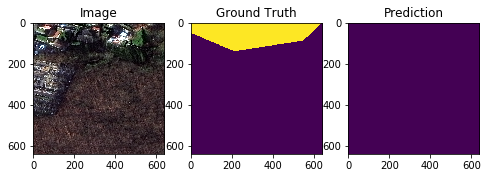

In [7]:
# # If you need to load the model, you can use these lines.
# model = get_unet()
# model.load_weights('checkpoints/weights.-0.57.hdf5')

# Pick an image with some positive pixels in the target
for i in range(Y_val.shape[0]):
    if Y_val[i].sum() > 5000:
        break
X = X_val[i]
Y = Y_val[i]

# Pick out which target to look at
CLASS_NO = 0
targ = Y[:, :, CLASS_NO]

# Run the model on that sample
pred = model.predict(X[None, ...])[0, :, :, CLASS_NO]

# Plot it
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4))
ax1.imshow(scale_bands(X[:,:,[4,2,1]])) # This index starts at 0, so I had to decrement
ax2.imshow(targ)
ax3.imshow(pred)

ax1.set_title('Image')
ax2.set_title('Ground Truth')
ax3.set_title('Prediction')

Whoops... it looks like this model isn't very smart. There are a few possibilities for why this happend.  Most likely, we need to train the model more, or the training set is just too imbalanced, since there really aren't a ton of positive examples in the training data.

**Suggested solutions:**
1. Train longer
2. Get more training data
3. Force the training set to be more balanced

I want to reiterate that Paris does not have a ton of data, so I would reccomend checking out Shanghai, Khartoum, or Vegas.